# import + functions

import os

In [421]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt  
import json

def make_transition_df(df):
    transitions = []
    in_in_Latency = []
    for index in range(len(df.Port.values)):
        if index < len(df.Port.values)-1:
            transit = int(str(df.Port.values[index]) + str(df.Port.values[index+1]))
            transitions += [transit]
            in_in_diff = df.PokeIn_Time.values[index+1] - df.PokeIn_Time.values[index]
            in_in_Latency += [in_in_diff]
        
 
    transit_df = pd.DataFrame({'Trial_id': df.Trial_id.values[0:-1], 
                                'Transition_type': transitions,
                                'in_in_Latency': in_in_Latency,
                                '2s_Time_Filter_in_in': list((np.array(in_in_Latency) <= 2).astype(int))})
    return transit_df

def get_mean_port_port_transition_latencies(day1_path):
    raw_poke_path = os.path.join(day1_path, np.array(os.listdir(day1_path))[['.csv' in file for file in os.listdir(day1_path)]][0])
    raw_pokes = pd.read_csv(raw_poke_path)
    raw_transits = make_transition_df(raw_pokes)
    mean_port_port_transition_latencies = np.mean(raw_transits['in_in_Latency'].values)
    return mean_port_port_transition_latencies

# main

In [422]:
# pull in the data and calculate deltas
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\"

replay_type = 'sequential_NREM_and_REM_sleep'


In [423]:
os.listdir(data_path)[14]

'EJT269_1_4'

In [424]:
# create dfs to hold the data
predictor_matrix_general_df = pd.DataFrame()
predictor_matrix_motif_df = pd.DataFrame()
outcome_matrix_general_df = pd.DataFrame()
outcome_matrix_motif_df = pd.DataFrame()

for mir in os.listdir(data_path):
    Tracking = False
    Pokes1 = False
    Pokes2 = False
    
    current_path = os.path.join(data_path, mir)
    # only bother loading any of the data if there is replay data saved out. 
    if 'replay' in os.listdir(current_path):#
        print('-------------------------------')
        print(f"Processing {mir}")
        replay_path = os.path.join(current_path, 'replay',replay_type)
        # load replay json 
        json_path = replay_path + r'\replay_data_variables.json'
        with open(json_path, 'r') as file:
            replay_data = json.load(file)
            print(f"Loaded replay data for {mir} from {json_path} ✓ ")
            
        # load in beahvioural data
        for file in os.listdir(current_path):
            if 'day2' in file:
                day2_path = os.path.join(current_path, file)
                # i forgot to do this in the preprocessing, so i added it in here 
                mean_port_port_transition_latencies_2 = get_mean_port_port_transition_latencies(day2_path)
                if 'processed' in os.listdir(day2_path):
                    processed_poke_data_2 = pd.read_csv(os.path.join(day2_path, 'processed', 'processed_poke_data_2.csv'))
                    processed_poke_data_2['transition_times'] = mean_port_port_transition_latencies_2
                    print(f"Loaded poke data 2 for {day2_path} ✓ ")
                    Pokes2 = True
                    try:
                        processed_tracking_data_2 = pd.read_csv(os.path.join(day2_path, 'processed', 'processed_tracking_data.csv'))
                        Tracking = True
                        print(f"Tracking data 2 found for {day2_path} ✓ ")
                    except:
                        print(f"Tracking data not found for {day2_path} ✗")
                        Tracking = False
        for file in os.listdir(current_path):
            if 'day1' in file:
                day1_path = os.path.join(current_path, file)
                # i forgot to do this in the preprocessing, so i added it in here 
                mean_port_port_transition_latencies_1 = get_mean_port_port_transition_latencies(day1_path)
                if 'processed' in os.listdir(day1_path):
                    processed_poke_data_1 = pd.read_csv(os.path.join(day1_path, 'processed', 'processed_poke_data_1.csv'))
                    processed_poke_data_1['transition_times'] = mean_port_port_transition_latencies_1
                    Pokes1 = True
                    print(f"Loaded poke data 1 for {day1_path} ✓ ")
                    try:
                        processed_tracking_data_1 = pd.read_csv(os.path.join(day1_path, 'processed', 'processed_tracking_data.csv'))
                        Tracking = True
                        print(f"Tracking data 1 found for {day1_path} ✓ ")
                    except:
                        print(f"Tracking data not found for {day1_path} ✗")
                        Tracking = False
                        
        if Pokes1 * Pokes2 == True:
            #### Add replay data (predictor) to dataframes
            
            # add all the data to dataframes
            predictor_general_dict = {}
            predictor_general_dict['animal_id'] = mir
            for key, val in replay_data.items():
                if 'motif' not in key:
                    mean_val = np.mean(val) if np.ndim(val) > 0 else val
                    predictor_general_dict.setdefault(key, []).append(mean_val)
                    
            if Tracking:
                predictor_motif_dict = {}
                for key, val in replay_data.items():
                    predictor_motif_dict['animal_id'] = [mir] * len(replay_data['motif_event_rpm'])
                    if 'motif' in key:
                        if np.ndim(replay_data[key][0]) > 0:
                            vals = [np.nanmean(value) for value in replay_data[key]]
                        else:
                            vals = val
                        predictor_motif_dict[key] = vals
                
            #concatenate to DataFrame
            predictor_matrix_general_df = pd.concat([predictor_matrix_general_df, pd.DataFrame(predictor_general_dict)], ignore_index=True)
            if Tracking:
                
                # only keep df rows which appear in the task_relevant_sequences
                task_relevant_sequences = processed_tracking_data_1.sequence_motif.values - 1 
                current_predictor_matrix = pd.DataFrame(predictor_motif_dict)
                current_predictor_matrix = current_predictor_matrix[current_predictor_matrix.index.isin(task_relevant_sequences)]
                current_predictor_matrix['sequence_motif'] = sorted(task_relevant_sequences)
                predictor_matrix_motif_df = pd.concat([predictor_matrix_motif_df, current_predictor_matrix], ignore_index=True)


            #################
            ## calculate behvaioural deltas
            delta_behavioural_data = processed_poke_data_2 - processed_poke_data_1
            if Tracking:
                delta_tracking_data = processed_tracking_data_2 - processed_tracking_data_1
                
            delta_behavioural_data['mouse_id'] = mir
            if Tracking:
                delta_tracking_data['mouse_id'] = [mir] * len(delta_tracking_data)   
                
            # add deltas to dataframes
            outcome_matrix_general_df = pd.concat([outcome_matrix_general_df, delta_behavioural_data], ignore_index=True)
            if Tracking:
                outcome_matrix_motif_df = pd.concat([outcome_matrix_motif_df, delta_tracking_data], ignore_index=True)

 




-------------------------------
Processing EJT136_1_3
Loaded replay data for EJT136_1_3 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\replay\sequential_NREM_and_REM_sleep\replay_data_variables.json ✓ 
Loaded poke data 2 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day2_12-11-2021 ✓ 
Tracking data 2 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day2_12-11-2021 ✓ 
Loaded poke data 1 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day1_11-11-2021 ✓ 
Tracking data 1 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day1_11-11-2021 ✓ 
-------------------------------
Processing EJT136_1_4
Loaded replay data for EJT136_1_4 from Z:\projects\sequen

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\1220364679.py:77: RuntimeWarning: Mean of empty slice
  vals = [np.nanmean(value) for value in replay_data[key]]


Loaded replay data for EJT269_1_4 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\replay\sequential_NREM_and_REM_sleep\replay_data_variables.json ✓ 
Loaded poke data 2 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day2_19-05-2023 ✓ 
Tracking data 2 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day2_19-05-2023 ✓ 
Loaded poke data 1 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day1_18-05-2023 ✓ 
Tracking data 1 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day1_18-05-2023 ✓ 
-------------------------------
Processing EJT270_1_6
Loaded replay data for EJT270_1_6 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_lin

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\1220364679.py:77: RuntimeWarning: Mean of empty slice
  vals = [np.nanmean(value) for value in replay_data[key]]


# issues:

something is wrong with the way i am setting up the predictor and outcome matricies for the tracking/motifs

I need a better way of accounting for nans (these happen when there is no replay of the motif!) currnelty they are just discounted but they should count! 


# calculate omnibus values 
(weighted average which describes whether how behaviour changed over sessions)

First for the poke data:

In [425]:
# remebr these are deltas
# so if the value is positive, it means the value has increased from day 1 to day 2 

# 1) flip the sign of any columns which are negative in the outcome matrix (eg. higher error rate = lower performance )
negative_columns = ['error_transit_rate', 'neutral_transit_rate', 'transits_per_reward', 'seconds_per_reward']
flipped_outcome_matrix_general_df = outcome_matrix_general_df.copy()
for col in negative_columns:
    if col in flipped_outcome_matrix_general_df.columns:
        flipped_outcome_matrix_general_df[col] = -flipped_outcome_matrix_general_df[col]


# 2) zscore each column in the outcome matrices
zscore_outcome_matrix_general_df = flipped_outcome_matrix_general_df.copy()
# drop the mouse_id column if it exists
zscore_outcome_matrix_general_df = zscore_outcome_matrix_general_df.drop(columns=['mouse_id'])
#apply z-scoring to just those
zscore_outcome_matrix_general_df = zscore_outcome_matrix_general_df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 3) make a weighted dataframe for each column in the outcome matrix
num_trials_weight = 0 # I think this is probably irrelevant for performance
correct_transit_rate_weight = 1
error_transit_rate_weight = 10 
neutral_transit_rate_weight = 0.2
perf_score_weight = 1
total_transitions_weight = 0
transits_per_reward_weight = 0.5
seconds_per_reward_weight = 0.7
transition_times_weight = 1 

# make a weighted vector
weights_vector = np.array([num_trials_weight, correct_transit_rate_weight, error_transit_rate_weight, neutral_transit_rate_weight, perf_score_weight, total_transitions_weight, transits_per_reward_weight, seconds_per_reward_weight, transition_times_weight])

# normalise the weights so they sum to 1
weights_vector_normalised = weights_vector/sum(weights_vector)

# dot product the weights with the z-scored outcome matrix: dot procut is element wise multiplication by weight then summing across the columns
overall_omnibus_deltas_per_animal = zscore_outcome_matrix_general_df.dot(weights_vector_normalised)

omnibus_delta_df = pd.DataFrame({'mouse_id': outcome_matrix_general_df['mouse_id'],
    'overall_delta' : overall_omnibus_deltas_per_animal})
# units are SD units - “SD units” just means you’re expressing a score in multiples of the standard deviation of the distribution - a zscore


now for the tracking/motif data 

In [426]:

# 1) flip the sign of any columns which are negative in the outcome matrix (eg. higher error rate = lower performance )
negative_columns = ['mean_h_distance_from_av_mm', 'std_h_distance_from_av_mm', 'mean_dtw_distance_from_av_mm', 'std_dtw_distance_from_av_mm','std_movement_speed_mm_s']
flipped_outcome_matrix_motif_df = outcome_matrix_motif_df.copy()
for col in negative_columns:
    if col in flipped_outcome_matrix_motif_df.columns:
        flipped_outcome_matrix_motif_df[col] = -flipped_outcome_matrix_motif_df[col]
        
# 2) zscore each column in the outcome matrices
zscore_outcome_matrix_motif_df = flipped_outcome_matrix_motif_df.copy()
# drop the mouse_id column if it exists
zscore_outcome_matrix_motif_df = zscore_outcome_matrix_motif_df.drop(columns=['mouse_id','sequence_motif'])
#apply z-scoring to just those
zscore_outcome_matrix_motif_df = zscore_outcome_matrix_motif_df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 3) make a weighted dataframe for each column in the outcome matrix
mean_h_distance_from_av_mm = 1 
std_h_distance_from_av_mm = 0.5
mean_dtw_distance_from_av_mm = 0
std_dtw_distance_from_av_mm = 0
mean_movement_speed_mm_s = 1
std_movement_speed_mm_s = 0.2
            
# make a weighted vector
weights_vector = np.array([mean_h_distance_from_av_mm, std_h_distance_from_av_mm, 
    mean_dtw_distance_from_av_mm, std_dtw_distance_from_av_mm, 
    mean_movement_speed_mm_s, std_movement_speed_mm_s
])

# normalise the weights so they sum to 1
weights_vector_normalised = weights_vector/sum(weights_vector)

# dot product the weights with the z-scored outcome matrix: dot procut is element wise multiplication by weight then summing across the columns
overall_omnibus_deltas_per_motif = zscore_outcome_matrix_motif_df.dot(weights_vector_normalised)

omnibus_delta_motifs_df = pd.DataFrame({'mouse_id': outcome_matrix_motif_df['mouse_id'],
    'overall_delta' : overall_omnibus_deltas_per_motif})
# units are SD units - “SD units” just means you’re expressing a score in multiples of the standard deviation of the distribution - a zscore


Text(0, 0.5, 'Omnibus motif deltas (SD units)')

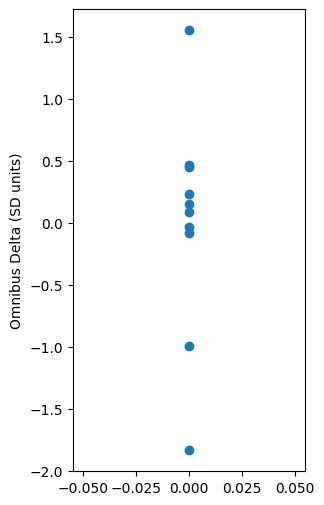

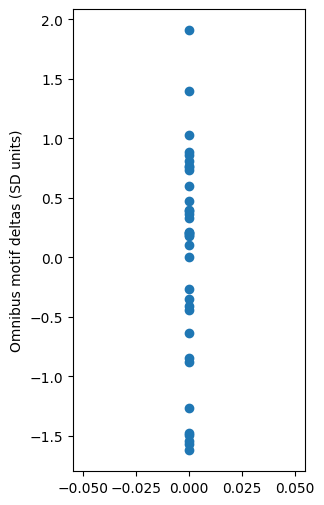

In [356]:

fig, ax = plt.subplots(figsize=(3, 6))
ax.plot(np.zeros(len(omnibus_delta_df.overall_delta.values)),omnibus_delta_df.overall_delta.values,'o')
ax.set_ylabel('Omnibus Delta (SD units)')

fig, ax = plt.subplots(figsize=(3, 6))
ax.plot(np.zeros(len(omnibus_delta_motifs_df.overall_delta.values)),omnibus_delta_motifs_df.overall_delta.values,'o')
ax.set_ylabel('Omnibus motif deltas (SD units)')


In [357]:
## make some basic plots of the omnibus deltas vs predictor variables

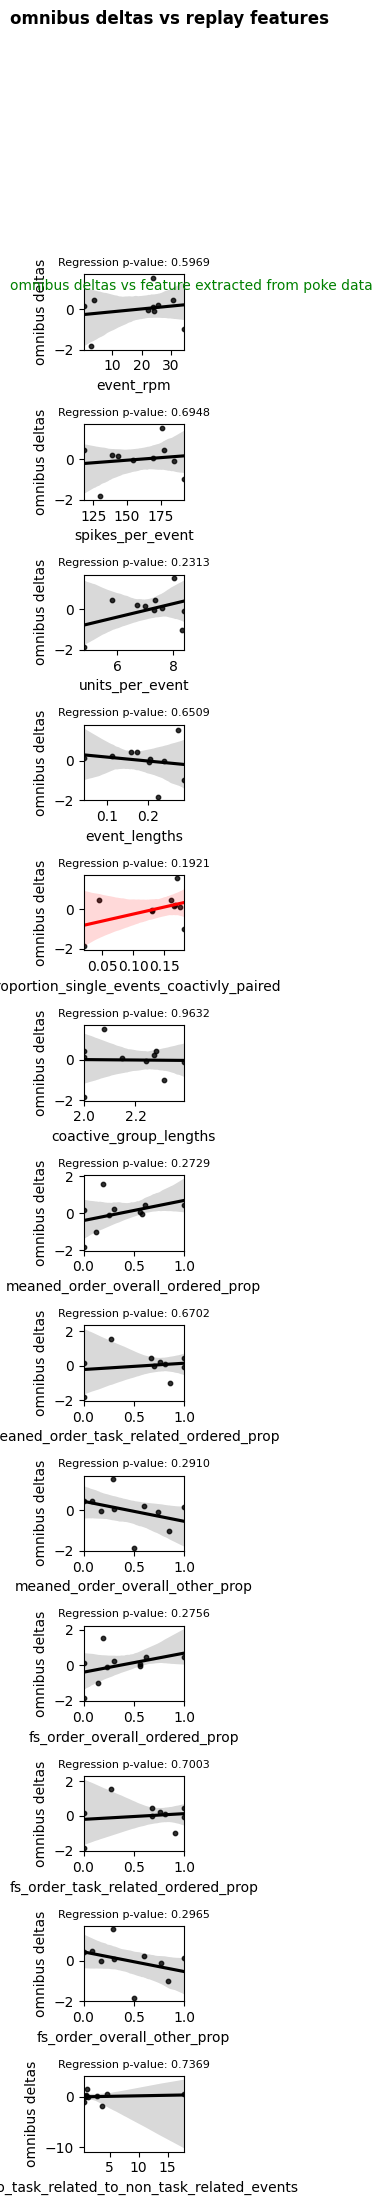

In [358]:
import scipy
import seaborn as sns

def regression_plot(var1, var2, string1, string2,ax):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(var1, var2)
    if p_value < 0.2:
        sns.regplot(x=var1, y=var2, ax=ax, scatter_kws={'color': 'black', 's': 10}, line_kws={'color': 'red'})
    else:
        sns.regplot(x=var1, y=var2, ax=ax, scatter_kws={'color': 'black', 's': 10}, line_kws={'color': 'black'})
    ax.set_xlabel(string1, size = 10)
    ax.set_ylabel(string2, size = 10)
    ax.set_title(f'Regression p-value: {p_value:.4f}', size = 8)    
    
    # Make axis numbers smaller
    ax.tick_params(axis='both', labelsize=10)
    return p_value

def plot_regressions_replay_vs_poke_data(var1,details,y_axis_data,all_mice_behav_vars_dict):
    fig, ax = plt.subplots(len(all_mice_behav_vars_dict.keys()) -1,1,figsize=(2, 20))
    plot_counter = 0
    for key in list(all_mice_behav_vars_dict):
        if not key == 'animal_id':
            regression_plot(all_mice_behav_vars_dict[key],y_axis_data,key,var1,ax[plot_counter])
            plot_counter += 1
    # Add a title above all subplots
    fig.suptitle(f'{var1} vs replay features', fontsize=12, fontweight="bold", x = 0,y = 1.1, ha = 'left')
    # Add a subheading using fig.text()
    fig.text(0, 0.96, f"{details} vs feature extracted from poke data", ha='left', fontsize=10, color = 'green')
    # Adjust layout for better spacing
    plt.tight_layout()  # Adjust bottom spacing
    
     
details = 'omnibus deltas'
y_axis_data = omnibus_delta_df.overall_delta.values
plot_regressions_replay_vs_poke_data(details,details,y_axis_data,predictor_matrix_general_df)

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\676307320.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = predictor_matrix_motif_df.applymap(lambda x: np.nan if isinstance(x, str) else x)


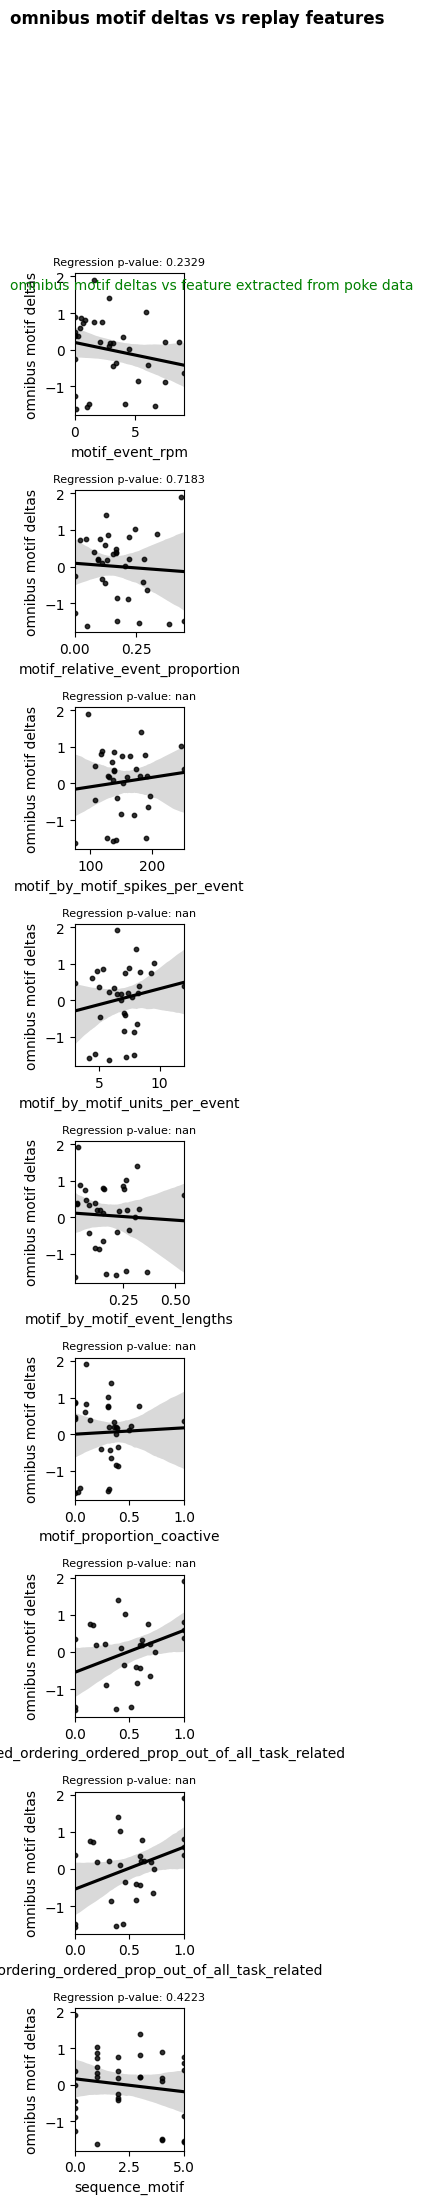

In [359]:
details = 'omnibus motif deltas'
y_axis_data = omnibus_delta_motifs_df.overall_delta.values
df = predictor_matrix_motif_df.applymap(lambda x: np.nan if isinstance(x, str) else x)
plot_regressions_replay_vs_poke_data(details,details,y_axis_data,df)

# what this code does:
This code performs a Ridge regression with Kfold cross-validation to evaluate how well a set of numerical predictors explain a target variable, after cleaning and standardizing the data. It then conducts a permutation test by randomly shuffling the target variable 1000 times to generate a null distribution of R² scores, allowing estimation of a p-value for the observed model performance. Finally, it prints the real cross-validated R² and p-value, and plots the distribution of shuffled R² scores against the real one.

Real CV R²: -1.035
Permutation p-value: 0.1000


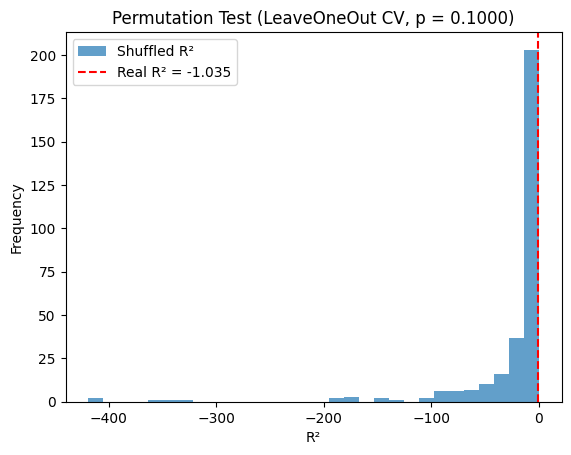

In [360]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold

# --- Inputs ---

X_array = predictor_matrix_general_df # shape: (n_samples, n_features)
y_array = omnibus_delta_df.overall_delta.values

# drop some more complex predictor comunns 
X_df = X_array.drop(columns = [ 'animal_id','proportion_single_events_coactivly_paired','units_per_event',
 'coactive_group_lengths',
 'meaned_order_overall_ordered_prop',
 'meaned_order_task_related_ordered_prop',
 'meaned_order_overall_other_prop',
 'fs_order_overall_ordered_prop',
 'fs_order_task_related_ordered_prop',
 'fs_order_overall_other_prop',
 'Ratio_task_related_to_non_task_related_events'])

# --- Scale predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
y = np.array(y_array)

# --- Model ---
cv = KFold(n_splits=3, shuffle=True, random_state=42)
ridge_model = Ridge(alpha=0.1)

# --- Real R² ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    real_r2_scores = cross_val_score(ridge_model, X_scaled, y, cv=cv, scoring='r2')
real_r2 = np.nanmean(real_r2_scores)

# --- Permutation test ---
n_perm = 300
shuffled_r2s = []

for _ in range(n_perm):
    y_shuffled = np.random.permutation(y)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_val_score(ridge_model, X_scaled, y_shuffled, cv=cv, scoring='r2')
    shuffled_r2s.append(np.nanmean(scores))

# --- p-value ---
p_val = np.mean(np.array(shuffled_r2s) >= real_r2)

# --- Output ---
print(f"Real CV R²: {real_r2:.3f}")
print(f"Permutation p-value: {p_val:.4f}")

# --- Plot ---
plt.hist(shuffled_r2s, bins=30, alpha=0.7, label='Shuffled R²')
plt.axvline(real_r2, color='red', linestyle='--', label=f'Real R² = {real_r2:.3f}')
plt.xlabel('R²'); plt.ylabel('Frequency')
plt.title(f'Permutation Test (LeaveOneOut CV, p = {p_val:.4f})')
plt.legend()
plt.show()



C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\1673262263.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_df= X_df.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)


Real CV R²: -1.736
Permutation p-value: 0.9300


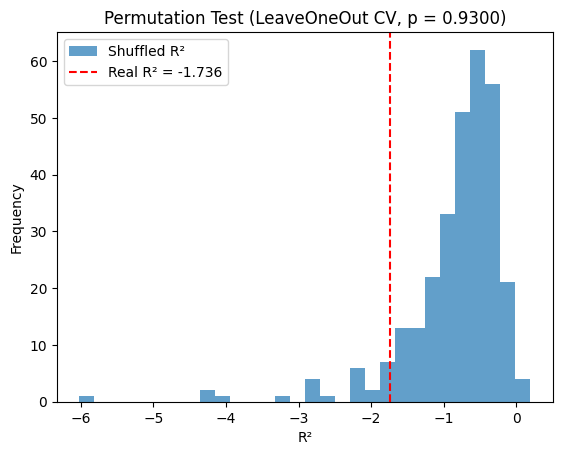

In [361]:


# --- Inputs ---


X_array = predictor_matrix_motif_df # shape: (n_samples, n_features)
y_array = omnibus_delta_motifs_df.overall_delta.values

# drop some more complex predictor comunns 
X_df = X_array.drop(columns = ['animal_id',
 'motif_proportion_coactive',
 'motif_meaned_ordering_ordered_prop_out_of_all_task_related',
 'motif_fs_ordering_ordered_prop_out_of_all_task_related',
 'sequence_motif'])

X_df= X_df.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)

# --- Scale predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
y = np.array(y_array)

# --- Model ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_model = Ridge(alpha=0.1)

# --- Real R² ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    real_r2_scores = cross_val_score(ridge_model, X_scaled, y, cv=cv, scoring='r2')
real_r2 = np.nanmean(real_r2_scores)

# --- Permutation test ---
n_perm = 300
shuffled_r2s = []

for _ in range(n_perm):
    y_shuffled = np.random.permutation(y)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_val_score(ridge_model, X_scaled, y_shuffled, cv=cv, scoring='r2')
    shuffled_r2s.append(np.nanmean(scores))

# --- p-value ---
p_val = np.mean(np.array(shuffled_r2s) >= real_r2)

# --- Output ---
print(f"Real CV R²: {real_r2:.3f}")
print(f"Permutation p-value: {p_val:.4f}")

# --- Plot ---
plt.hist(shuffled_r2s, bins=30, alpha=0.7, label='Shuffled R²')
plt.axvline(real_r2, color='red', linestyle='--', label=f'Real R² = {real_r2:.3f}')
plt.xlabel('R²'); plt.ylabel('Frequency')
plt.title(f'Permutation Test (LeaveOneOut CV, p = {p_val:.4f})')
plt.legend()
plt.show()


# dimensionality reduction methods
CCA - canonical correlation analysis
like PCA but instead of finding reduced dimensions that best describe the variance in the data it compresses the data onto two dimesnions that maximally correlate (one dimension each). You can then look at how each feature weights to each dimensions

In [596]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import numpy as np

def stadardise_data(X, Y):
    """
    Standardizes the input data X and Y.
    """
    X_scaled = StandardScaler().fit_transform(X)
    Y_scaled = StandardScaler().fit_transform(Y)
    return X_scaled, Y_scaled

from sklearn.linear_model import LinearRegression

def plot_canonical_variates(X_c, Y_c):
    """
    Plots the canonical variates.
    """
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        # Correlation between canonical variates
        r, _ = pearsonr(X_c[:, i], Y_c[:, i])
        print(f"Canonical correlation (component {i+1}): {r:.3f}")
        # Plot the canonical variates
        ax[i].scatter(X_c[:, i], Y_c[:, i])
        ax[i].set_xlabel('Behaviour (Canonical)')
        ax[i].set_ylabel('Replay (Canonical)')
        ax[i].set_title(f'r = {r:.2f} component {i+1}')
        
        # Fit regression model
        model = LinearRegression()
        model.fit(X_c[:, i].reshape(-1, 1), Y_c[:, i].reshape(-1, 1))

        # Predict y values
        y_pred = model.predict(X_c[:, i].reshape(-1, 1))

        ax[i].plot(X_c[:, i], y_pred, color='pink', label="Regression line")
                



chose data and run CCA

Canonical correlation (component 1): 0.988
Canonical correlation (component 2): 0.822
Canonical correlation (component 3): 0.381
Canonical correlation (component 4): 0.147


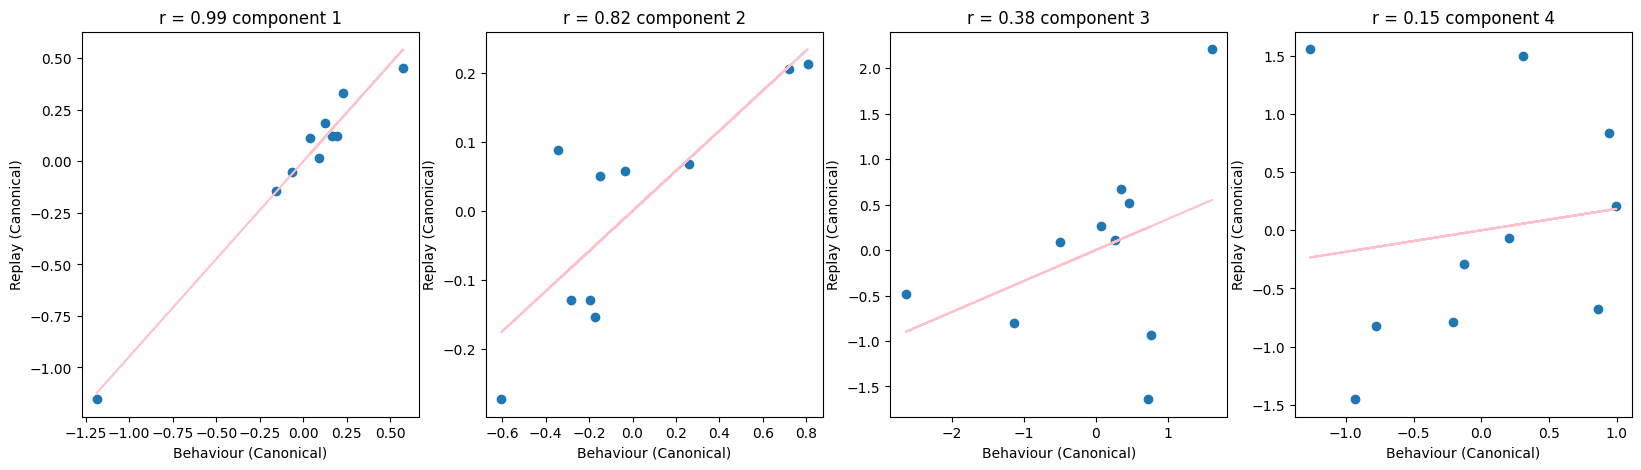

In [606]:
data_type = 'general' # or 'motif'  #depending on the type of data you want to plot

if data_type == 'general':

    ######## set up GENERAL ANIMAL LEVEL data for CCA ########

    X_array = predictor_matrix_general_df # shape: (n_samples, n_features)
    y_array = outcome_matrix_general_df.drop(columns=['mouse_id','num_trials'])

    # drop some more complex predictor comunns 
    X_df = X_array.drop(columns = ['animal_id',
    'proportion_single_events_coactivly_paired',
    'coactive_group_lengths',
    'meaned_order_overall_ordered_prop',
    'meaned_order_task_related_ordered_prop',
    'meaned_order_overall_other_prop',
    'fs_order_overall_ordered_prop',
    'fs_order_task_related_ordered_prop',
    'fs_order_overall_other_prop',
    'Ratio_task_related_to_non_task_related_events'])

    Y_df = y_array.drop(columns = [
    'error_transit_rate',
    'neutral_transit_rate',
    'total_transitions',
    'transits_per_reward'])

    X = X_df
    Y = Y_df

    ##############################################


elif data_type == 'motif':

    ######## set up MOTIF data for CCA ########

    X_array = predictor_matrix_motif_df # shape: (n_samples, n_features)
    Y = outcome_matrix_motif_df.drop(columns=['mouse_id','sequence_motif','mean_h_distance_from_av_mm',
    'std_h_distance_from_av_mm']).applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)

    # drop some more complex predictor comunns 
    X_df = X_array.drop(columns = ['animal_id',
    'motif_proportion_coactive',
    'motif_meaned_ordering_ordered_prop_out_of_all_task_related',
    'motif_fs_ordering_ordered_prop_out_of_all_task_related',
    'sequence_motif'])

    X= X_df.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)

    ##############################################




################# RUN CCA Analysis #################
# Standardize
X_scaled, Y_scaled = stadardise_data(X, Y)
# CCA
cca = CCA(n_components=4)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
# Plot canonical variates
plot_canonical_variates(X_c, Y_c)





permutation test for each component

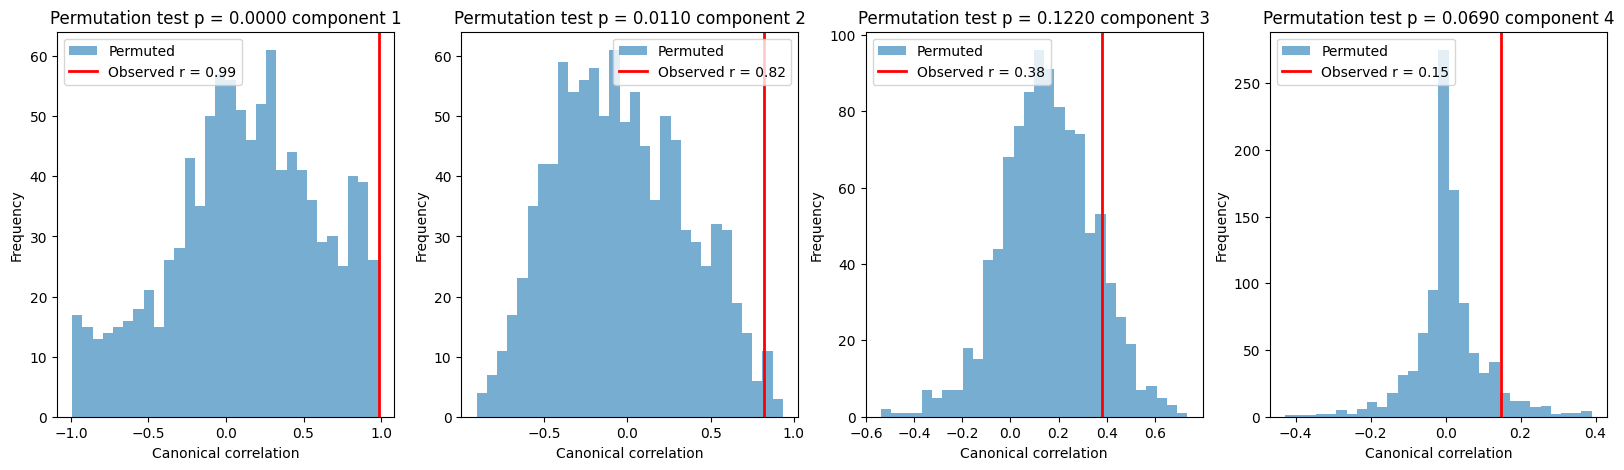

In [607]:
n_perms = 1000
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):

    perm_r = []
    for _ in range(n_perms):
        Y_perm = np.random.permutation(Y_scaled)
        _, Y_c_perm = cca.fit_transform(X_scaled, Y_perm)
        r_perm, _ = pearsonr(X_c[:, i], Y_c_perm[:, i])
        perm_r.append(r_perm)

    # True correlation
    X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
    
    r_true, _ = pearsonr(X_c[:, i], Y_c[:, i])

    p_val = np.mean(np.array(perm_r) >= r_true)


    ax[i].hist(perm_r, bins=30, alpha=0.6, label='Permuted')
    ax[i].axvline(r_true, color='red', linewidth=2, label=f'Observed r = {r_true:.2f}')
    ax[i].set_xlabel("Canonical correlation")
    ax[i].set_ylabel("Frequency")
    ax[i].set_title(f"Permutation test p = {p_val:.4f} component {i+1}")
    ax[i].legend()


extract the feature weights and bootstrap the data to get error bars

c:\miniconda\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\miniconda\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\miniconda\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


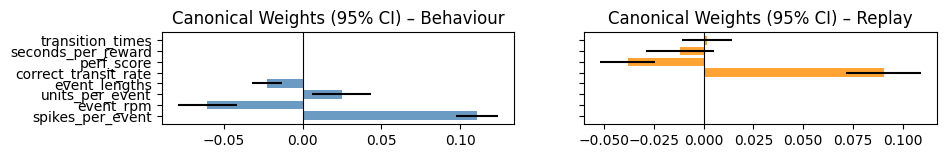

In [608]:
# --- Step 1: Standardize ---
X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y)

# --- Step 2: Fit CCA on full data ---
cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
x_weights = cca.x_weights_[:, 0]
y_weights = cca.y_weights_[:, 0]

# --- Step 3: Bootstrap ---
n_boots = 1000
x_weights_all = np.zeros((n_boots, X.shape[1]))
y_weights_all = np.zeros((n_boots, Y.shape[1]))

for i in range(n_boots):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    X_boot = X_scaled[idx]
    Y_boot = Y_scaled[idx]
    
    cca.fit(X_boot, Y_boot)
    x_weights_all[i] = cca.x_weights_[:, 0]
    y_weights_all[i] = cca.y_weights_[:, 0]

# --- Step 4: Compute 95% confidence intervals ---
x_mean = x_weights_all.mean(axis=0)
y_mean = y_weights_all.mean(axis=0)

x_err = scipy.stats.sem(x_weights_all, axis=0)
y_err = scipy.stats.sem(y_weights_all, axis=0)

# Sort by absolute weight magnitude
sorted_idx_x = np.argsort(-np.abs(x_mean))
sorted_idx_y = np.argsort(-np.abs(y_mean))

# Behaviour
beh_names = np.array(X.columns)[sorted_idx_x]
beh_vals = x_mean[sorted_idx_x]

# Replay
rep_names = np.array(Y.columns)[sorted_idx_y]
rep_vals = y_mean[sorted_idx_y]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, max(len(X.columns), len(Y.columns)) * 0.3), sharey=True)

axes[0].barh(beh_names, beh_vals, xerr= x_err, color='steelblue', alpha=0.8)
axes[0].set_title('Canonical Weights (95% CI) – Behaviour')
axes[0].axvline(0, color='black', linewidth=0.8)

axes[1].barh(rep_names, rep_vals, xerr=y_err, color='darkorange', alpha=0.8)
axes[1].set_title('Canonical Weights (95% CI) – Replay')
axes[1].axvline(0, color='black', linewidth=0.8)
